# Import Modules

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Load the Boston Housing dataset from datasets

In [4]:
Columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

housing_data = pd.read_csv('housing.csv', header=None, sep=r"\s+", names=Columns)

print(housing_data.head())

housing_data.describe()

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Preview Data

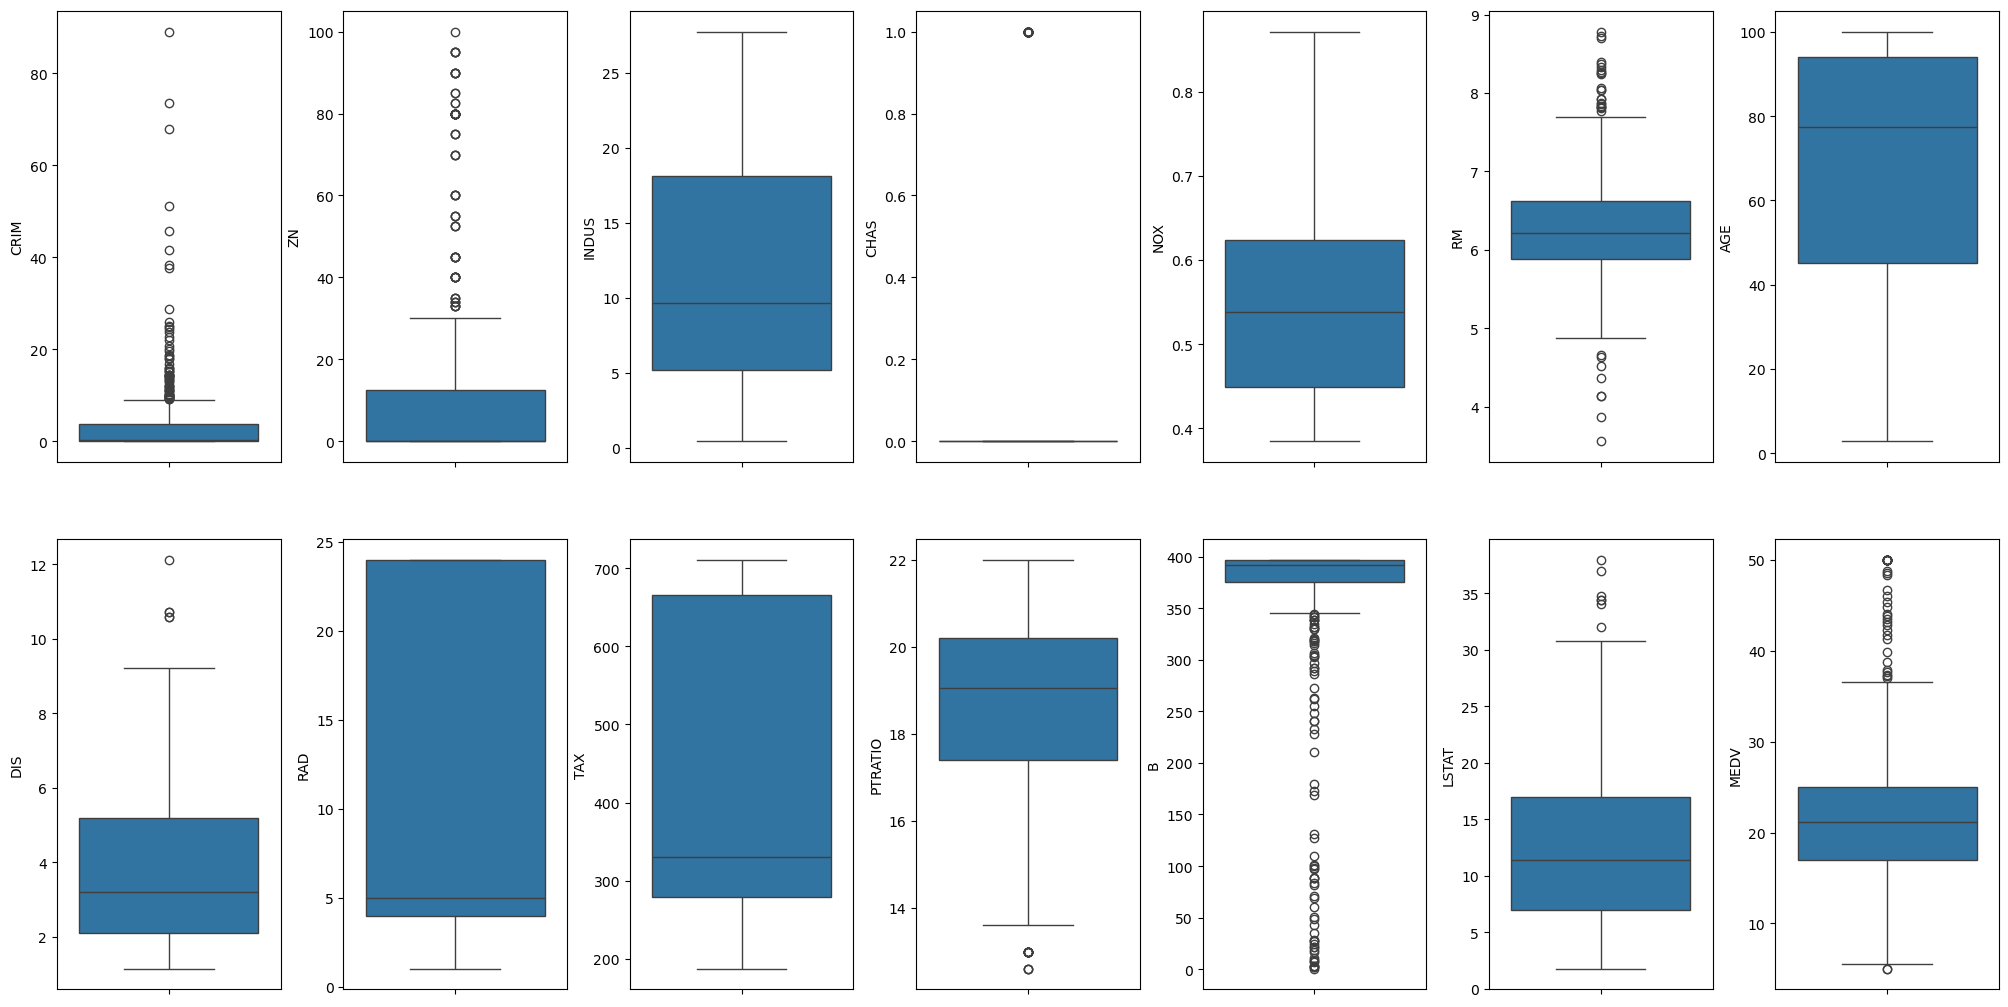

In [5]:
# As shown on the table above, two data coulmns show interesting summeries. They are : ZN (proportion of residential land zoned for lots over 25,000 sq.ft.) with 0 for 25th, 50th percentiles. Second, CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise) with 0 for 25th, 50th and 75th percentiles. These summeries are understandable as both variables are conditional + categorical variables. First assumption would be that these coulms may not be useful in regression task such as predicting MEDV (Median value of owner-occupied homes).
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

fig, axis = plt.subplots(ncols = 7, nrows = 2, figsize=(20, 10))
axs = axis.flatten()

for index, col in enumerate(housing_data.columns):
    sns.boxplot(y=col, data=housing_data, ax=axs[index])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

In [10]:
# CRIM, ZN, B and RM seem to have outliers, check them
for key, value in housing_data.items():
    Q1 = value.quantile(0.25)
    Q3 = value.quantile(0.75)
    IRQ = Q3 - Q1
    Range = value[(value <= Q1 - 1.5 * IRQ) | (value >= Q3 + 1.5 * IRQ)]
    perc = np.shape(Range)[0] * 100 / np.shape(housing_data)[0]
    print("Column %s outliers = %.2f%%" % (key, perc))

Column CRIM outliers = 13.04%
Column ZN outliers = 13.44%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.93%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.96%
Column B outliers = 15.22%
Column LSTAT outliers = 1.38%
Column MEDV outliers = 7.91%


In [11]:
# Let's remove MEDV outliers before plotting more distributions
# Most of datapoints in MEDV lie below 50 so we use ~ to reverse the condition
data = housing_data[~(housing_data['MEDV'] >= 50.0)]
print(np.shape(data))

(490, 14)


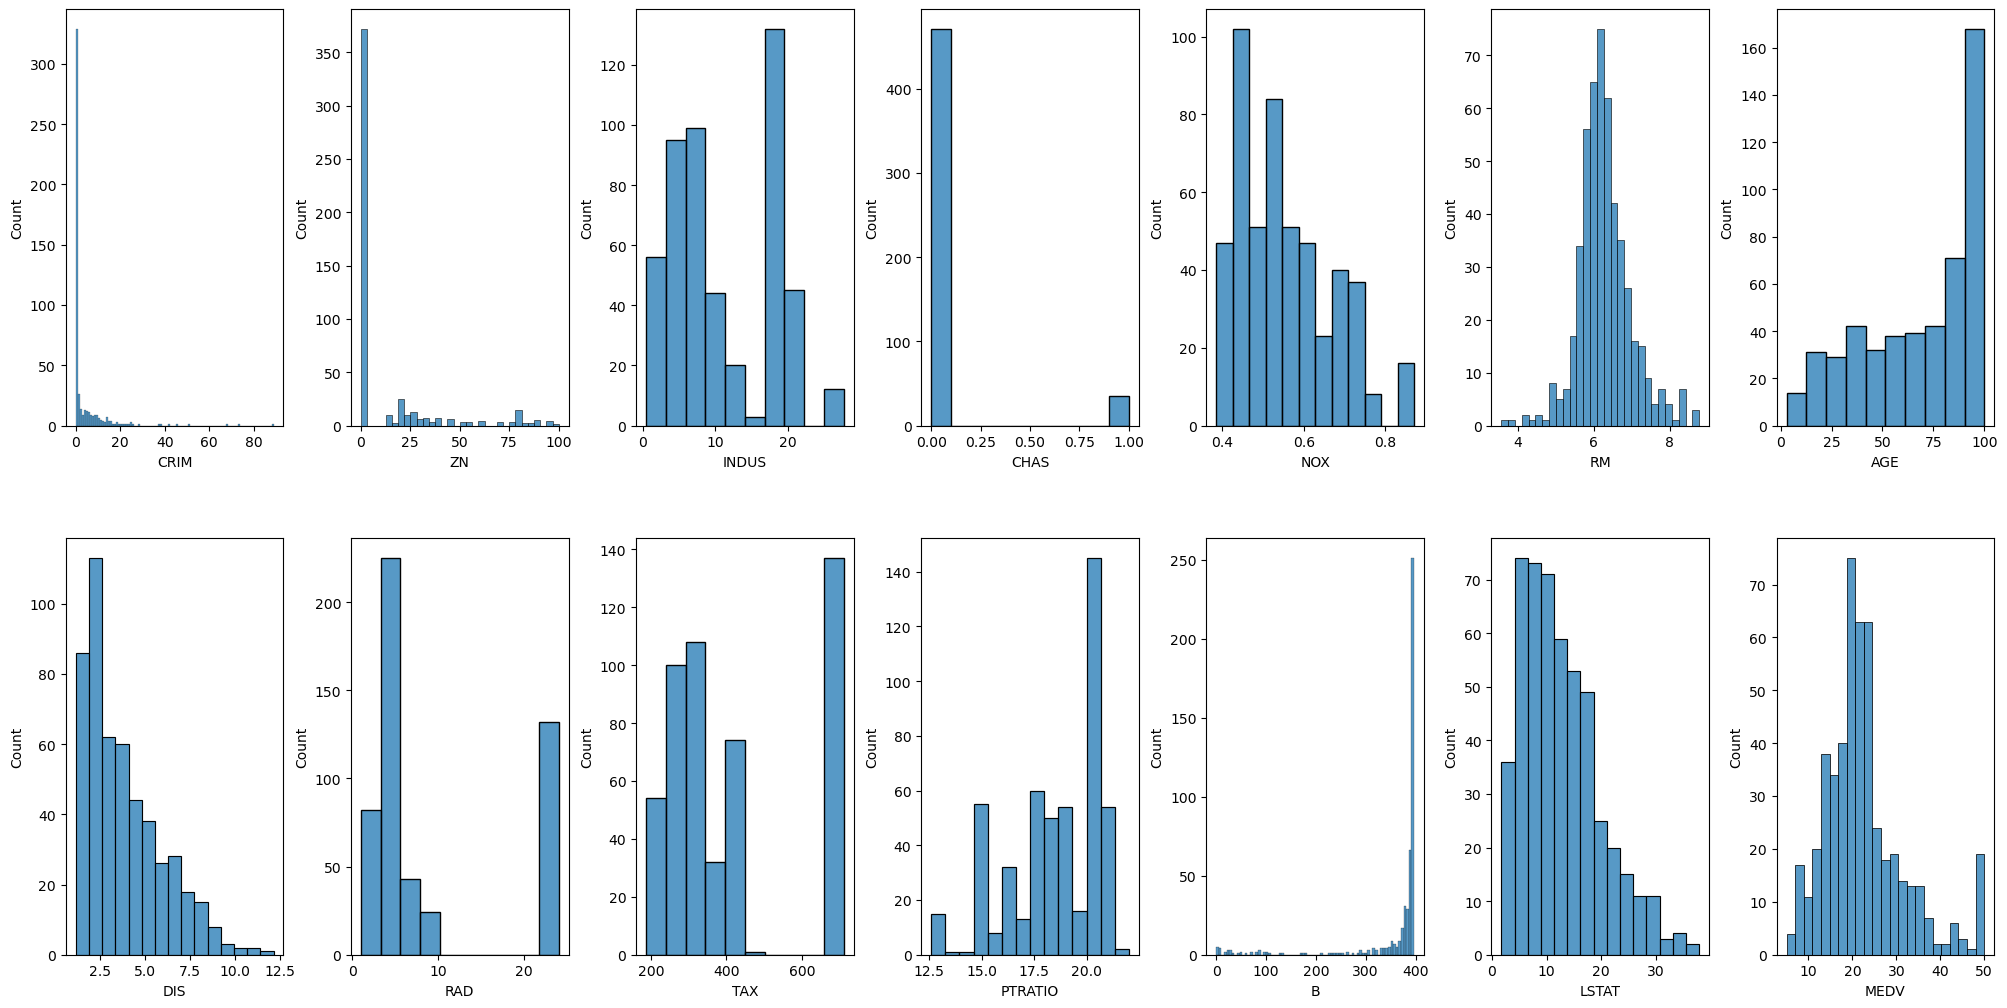

In [15]:
fig, axs = plt.subplots(ncols = 7, nrows = 2, figsize=(20, 10))
index = 0
axs = axs.flatten()

for k, v in housing_data.items():
    sns.histplot(v, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<Axes: >

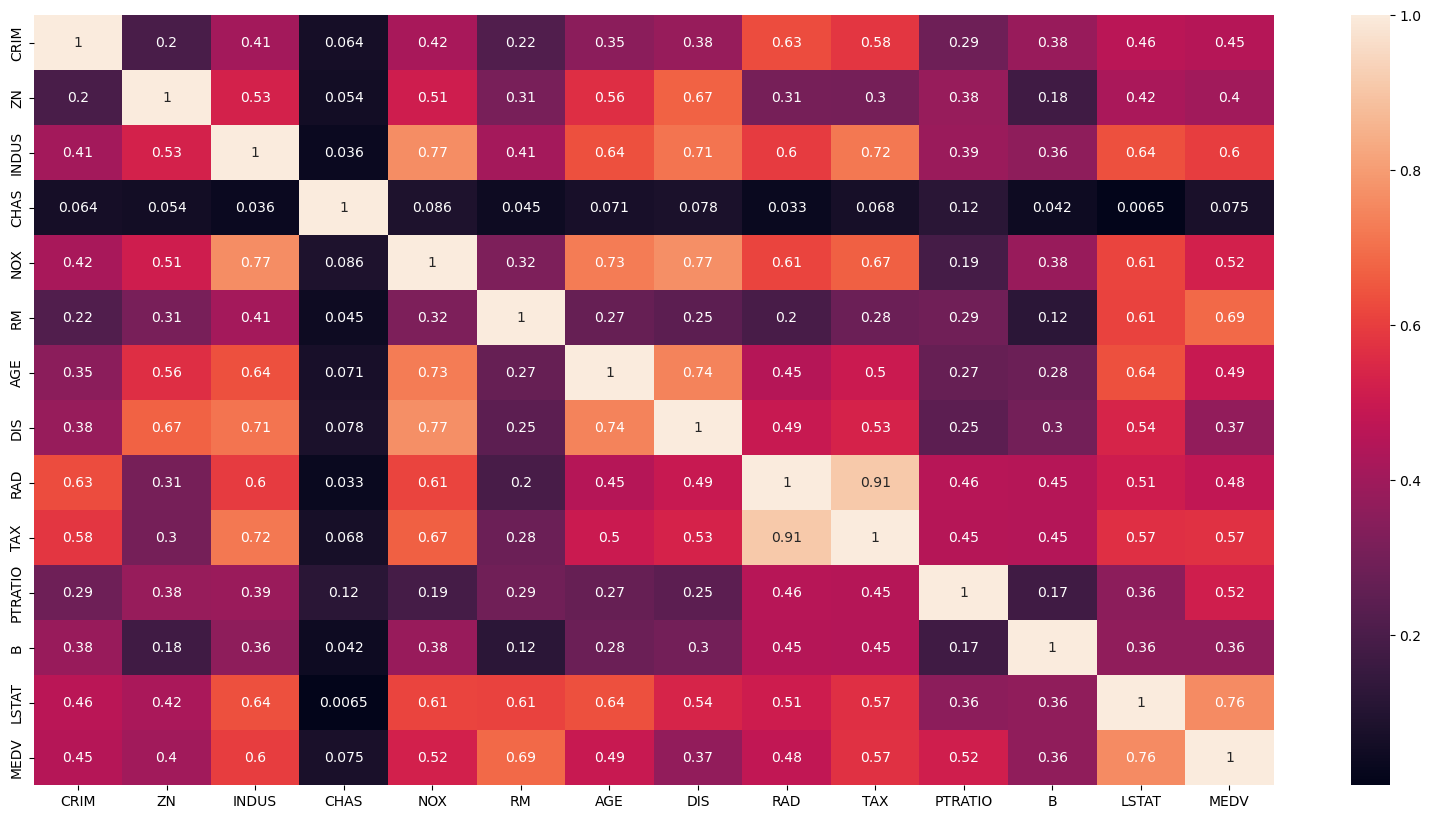

In [16]:
# Now plot the pairwise correlation on data
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs(), annot=True)

From correlation matrix, we see TAX and RAD are highly correlated features. The columns LSTAT, INDUS, RM, TAX, NOX, PTRAIO has a correlation score above 0.5 with MEDV which is a good indication of using as predictors. Let's plot these columns against MEDV.

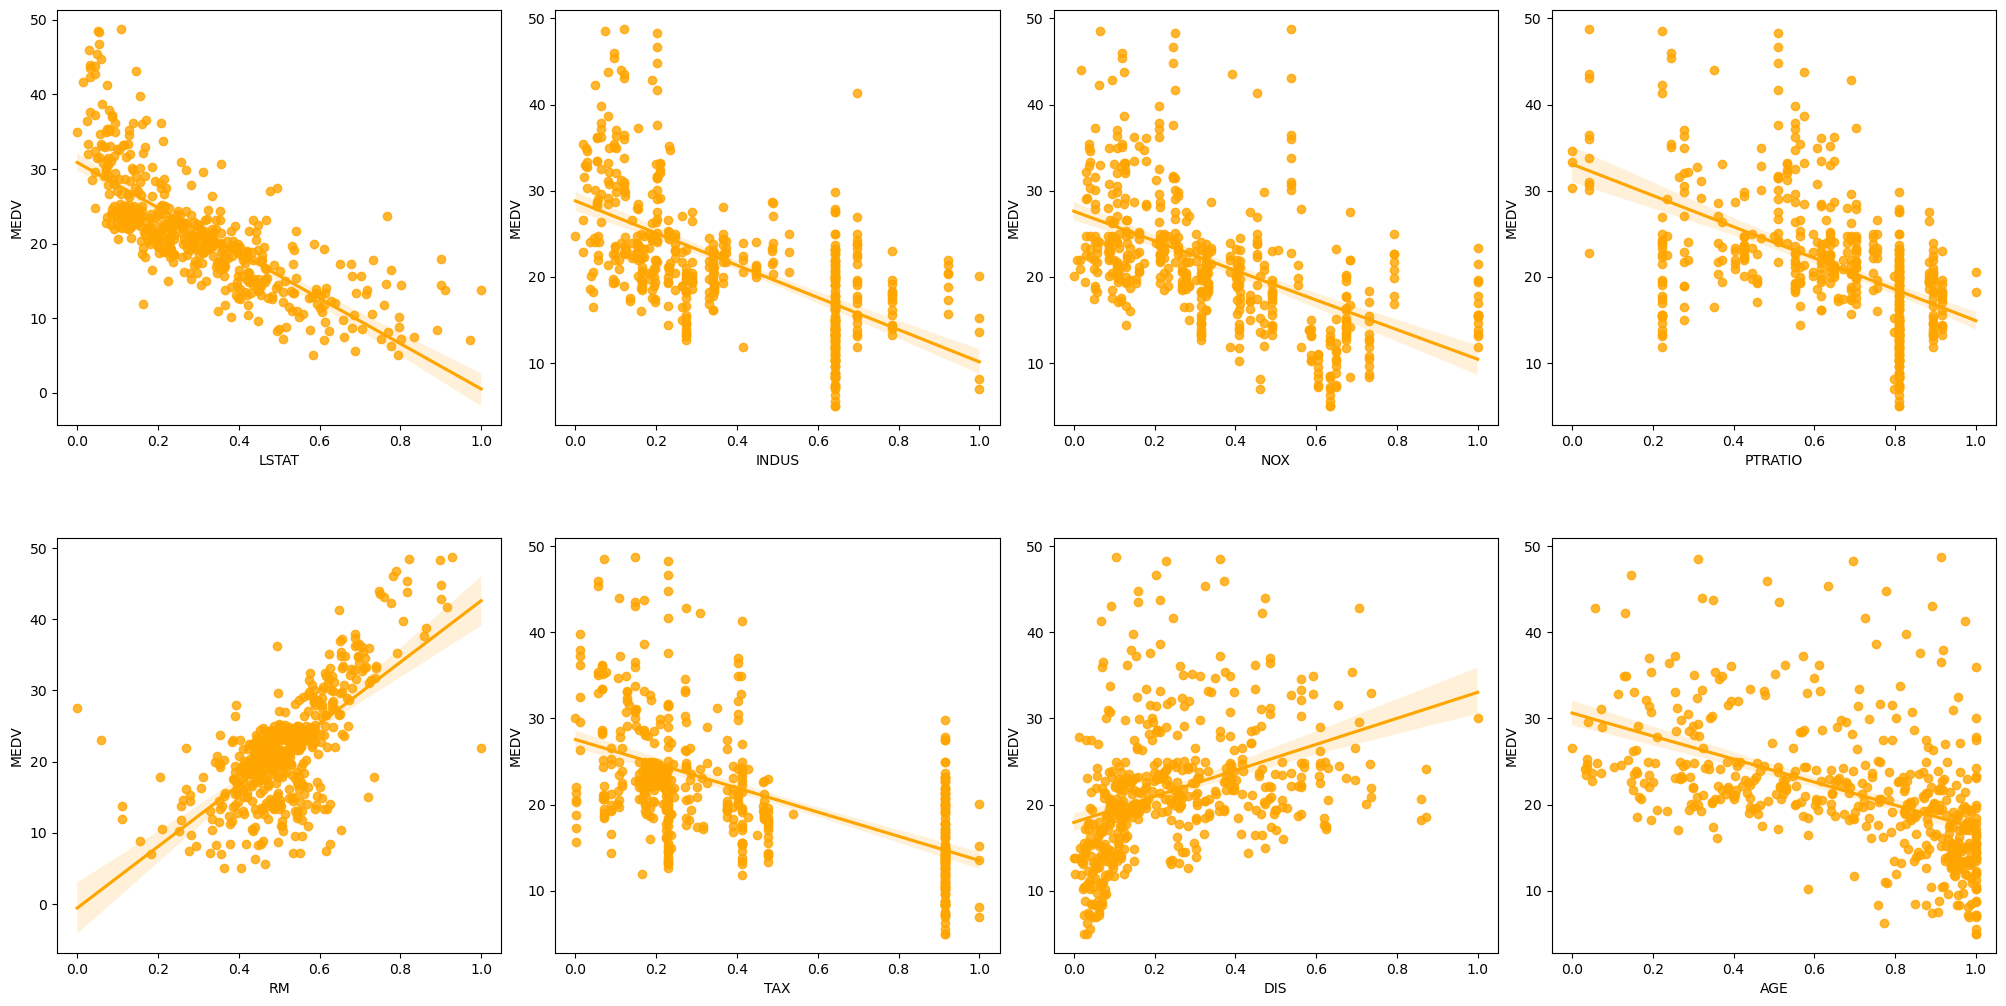

In [21]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
columns = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x_data = data.loc[:, columns]
y_data = data['MEDV']
x_label = pd.DataFrame(data = min_max_scaler.fit_transform(x_data), columns = columns)
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize=(20, 10))
index = 0
axs = axs.flatten()

for i, k in enumerate(columns):
    sns.regplot(y = y_data, x = x_label[k], ax = axs[i], color = 'orange')
plt.tight_layout(pad = 0.5, w_pad = 0.5, h_pad = 5)

So with these analsis, we may try predict MEDV with 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE' features. Let's try to remove the skewness of the data trough log transformation.

In [37]:
y = np.log1p(y_data)
for col in x_data.columns:
    if np.abs(x_data[col].skew()) > 0.3:
        x_data[col] = np.log1p(x_data[col])

In [60]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

# Linear Regression Model
scores_map = {}
linear = linear_model.LinearRegression()
kf = KFold(n_splits = 10)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_data)
scores_linear = cross_val_score(linear, x_scaled, y, cv = kf, scoring = 'neg_mean_squared_error')
print('MSE: %.2f (+/- %.2f)' % (scores_linear.mean(), scores_linear.std()))

# Ridge Regression Model
scores_map['LinearRegression'] = scores_linear
ridge = linear_model.Ridge()
scores_ridge = cross_val_score(ridge, x_scaled, y, cv = kf, scoring = 'neg_mean_squared_error')
scores_map['Ridge Regressor'] = scores_ridge
print('MSE: %.2f (+/- %.2f)' % (scores_ridge.mean(), scores_ridge.std()))

# Polynomial Regression Model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly = make_pipeline(PolynomialFeatures(degree = 3), linear_model.Ridge())
scores_poly = cross_val_score(poly, x_scaled, y, cv=kf, scoring = 'neg_mean_squared_error')
scores_map['Polynomial'] = scores_poly
print('MSE: %.2f (+/- %.2f)' % (scores_poly.mean(), scores_poly.std()))

MSE: -0.04 (+/- 0.04)
MSE: -0.04 (+/- 0.04)
MSE: -0.03 (+/- 0.03)


The Liner Regression with and without L2 regularization does not make significant difference is MSE score. However polynomial regression with degree=3 has a better MSE. Let's try some non prametric regression techniques: SVR with kernal rbf, DecisionTreeRegressor, KNeighborsRegressor etc.

In [55]:
# Support Vector Machine 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

SVR = SVR(kernel='rbf', C = 1, gamma = 0.1)
grid_sv = GridSearchCV(SVR, cv=kf, param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)}, scoring='neg_mean_squared_error')
grid_sv.fit(x_scaled, y)
print("Best classifier :", grid_sv.best_estimator_)

scores_SVR = cross_val_score(SVR, x_scaled, y, cv=kf, scoring = 'neg_mean_squared_error')
scores_map['SVR'] = scores_SVR
print("MSE: %.2f (+/- %.2f)" % (scores_SVR.mean(), scores_SVR.std()))

Best classifier : SVR(gamma=1.0)
MSE: -0.04 (+/- 0.04)


In [68]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth = 5)
grid_sv = GridSearchCV(decision_tree, cv=kf, param_grid={"max_depth" : [1, 2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
grid_sv.fit(x_scaled, y)
print("Best classifier :", grid_sv.best_estimator_)

scores_dt = cross_val_score(decision_tree, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Decision Tree'] = scores_dt
print('MSE: %.2f (+/- %.2f)' % (scores_dt.mean(), scores_dt.std()))

Best classifier : DecisionTreeRegressor(max_depth=4)
MSE: -0.05 (+/- 0.04)


In [69]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor(n_neighbors=8)
grid_sv = GridSearchCV(KNN, cv=kf, param_grid={"n_neighbors" : [2, 3, 4, 5, 6, 7, 8]}, scoring='neg_mean_squared_error')
grid_sv.fit(x_scaled, y)
print("Best classifier :", grid_sv.best_estimator_)

scores_KNN = cross_val_score(KNN, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['KNN'] = scores_KNN
print('KNN Accuracy: %.2f (+/- %.2f)' % (scores_KNN.mean(), scores_KNN.std()))

Best classifier : KNeighborsRegressor(n_neighbors=7)
KNN Accuracy: -0.04 (+/- 0.03)


Compared to three models which are shosen through grid search, KNN performes better. Let's try an ensemble method finally.

In [58]:
# Gradient Boost 
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(
    alpha = 0.9, 
    learning_rate = 0.1, 
    max_depth = 2, 
    min_samples_leaf = 5,
    min_samples_split = 2,
    n_estimators = 100,
    random_state = 30
)
param_grid={'n_estimators':[100, 200], 'learning_rate': [0.1,0.05,0.02], 'max_depth':[2, 4,6], 'min_samples_leaf':[3,5,9]}
grid_sv = GridSearchCV(GBR, cv=kf, param_grid=param_grid, scoring='neg_mean_squared_error')
grid_sv.fit(x_scaled, y)
print("Best classifier :", grid_sv.best_estimator_)

scores_GBR = cross_val_score(GBR, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['GBR'] = scores_GBR
print('MSE: %.2f (+/- %.2f)' % (scores_GBR.mean(), scores_GBR.std()))

Best classifier : GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_leaf=9,
                          random_state=30)
MSE: -0.03 (+/- 0.02)


Let's plot k-fold results to see which model has better distribution of results. Let's have a look at the MSE distribution of these models with k-fold=10

<Axes: >

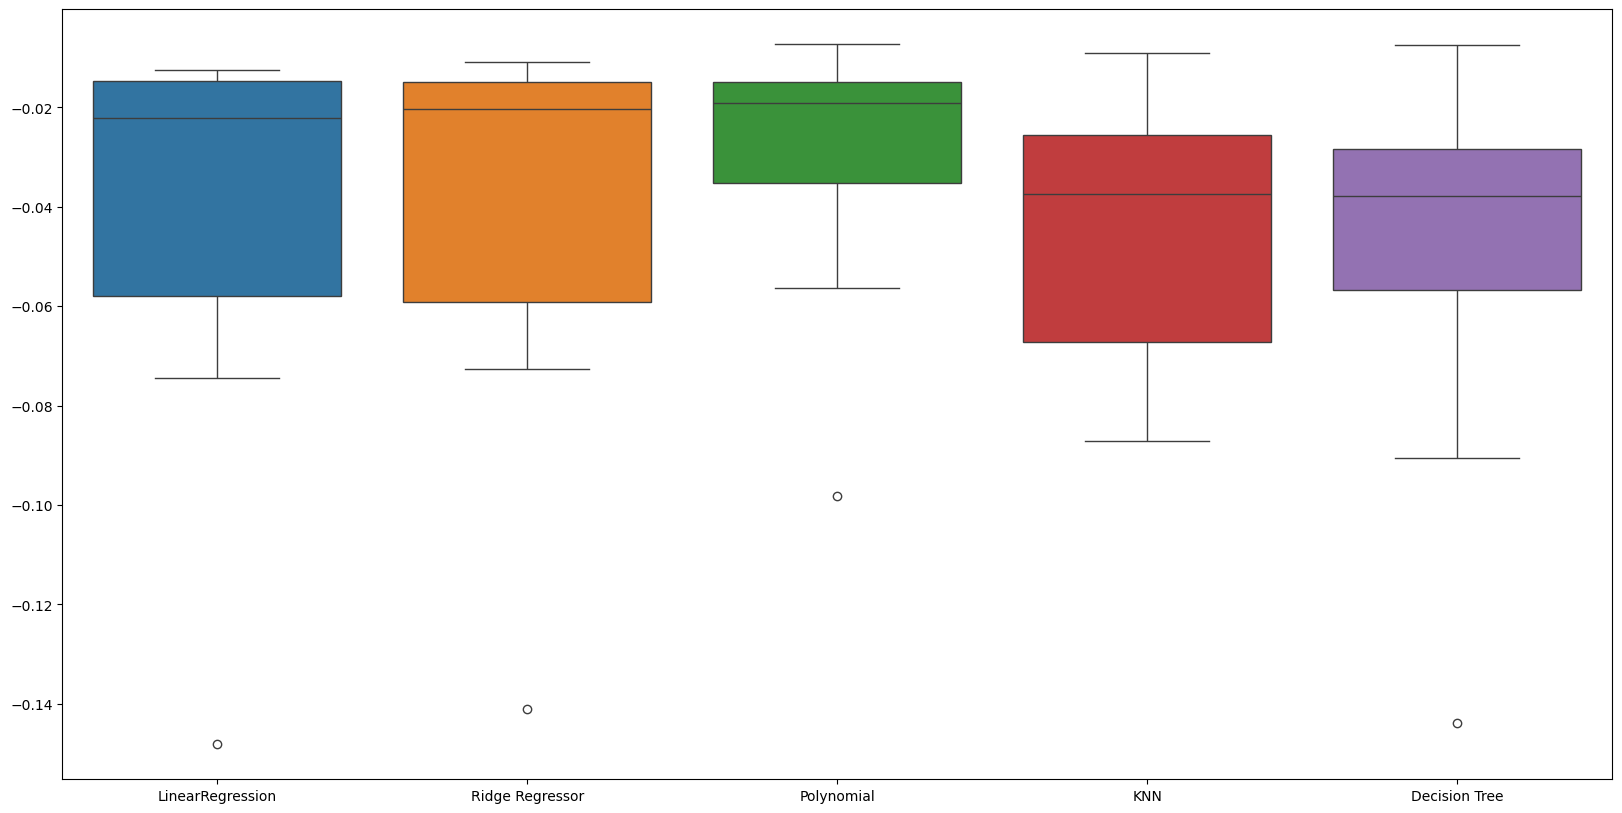

In [70]:
plt.figure(figsize=(20, 10))
final_scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=final_scores_map)